# Feature Engineering 1 Assignment

## Imports and Connection

In [77]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import warnings
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [23]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation', con=engine)

engine.dispose()

## Handling Missing Values

In [24]:
fill_list = ["ENROLL", 
            "TOTAL_REVENUE", 
            "FEDERAL_REVENUE", 
            "STATE_REVENUE", 
            "LOCAL_REVENUE", 
            "TOTAL_EXPENDITURE", 
            "INSTRUCTION_EXPENDITURE", 
            "SUPPORT_SERVICES_EXPENDITURE",
            "OTHER_EXPENDITURE", 
            "CAPITAL_OUTLAY_EXPENDITURE", 
            "GRADES_PK_G", 
            "GRADES_KG_G", 
            "GRADES_4_G", 
            "GRADES_8_G", 
            "GRADES_12_G", 
            "GRADES_1_8_G", 
            "GRADES_9_12_G", 
            "GRADES_ALL_G",
            "AVG_MATH_4_SCORE",
            "AVG_MATH_8_SCORE",
            "AVG_READING_4_SCORE",
            "AVG_READING_8_SCORE"]

In [50]:
edu2_df = education_df.copy()

states = edu2_df["STATE"].unique()

for state in states:
    edu2_df.loc[edu2_df["STATE"] == state, fill_list] = edu2_df.loc[edu2_df["STATE"] == state, fill_list].interpolate()

#drop the null values after interpolation
edu2_df.dropna(inplace=True)

## 1.) Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!**

## Feature Engineering

In [51]:
edu2_df['avg_4'] = (edu2_df['AVG_MATH_4_SCORE'] + edu2_df['AVG_READING_4_SCORE']) / 2
edu2_df['avg_8'] = (edu2_df['AVG_MATH_8_SCORE'] + edu2_df['AVG_READING_8_SCORE']) / 2
edu2_df['total_4_8'] = edu2_df['GRADES_4_G'] + edu2_df['GRADES_8_G']

edu2_df['overall_score'] = (edu2_df['avg_4'] * edu2_df['GRADES_4_G'] + edu2_df['avg_8'] * edu2_df['GRADES_8_G']) / edu2_df['total_4_8']

## 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [63]:
edu3_df = edu2_df.copy()
edu3_df = edu3_df.drop(columns = ['GRADES_ALL_G',
                                  'GRADES_9_12_G',
                                  'GRADES_1_8_G',
                                  'GRADES_12_G',
                                  'GRADES_1_8_G',
                                  'GRADES_12_G',
                                  'GRADES_8_G',
                                  'GRADES_4_G',
                                  'GRADES_KG_G',
                                  'GRADES_PK_G',
                                  'AVG_MATH_4_SCORE',
                                  'AVG_MATH_8_SCORE', 
                                  'AVG_READING_4_SCORE',
                                  'AVG_READING_8_SCORE', 
                                  'avg_4', 
                                  'avg_8', 
                                  'total_4_8'])
edu3_df.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,overall_score
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,1000914.0,164083.0,680139.0,236.637935
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,386526.0,68617.0,97824.0,236.905842
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,954032.0,92163.0,318959.0,243.634022
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,1190914.0,143312.0,186802.0,246.815311
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,207850.0,26548.0,47372.0,237.735539


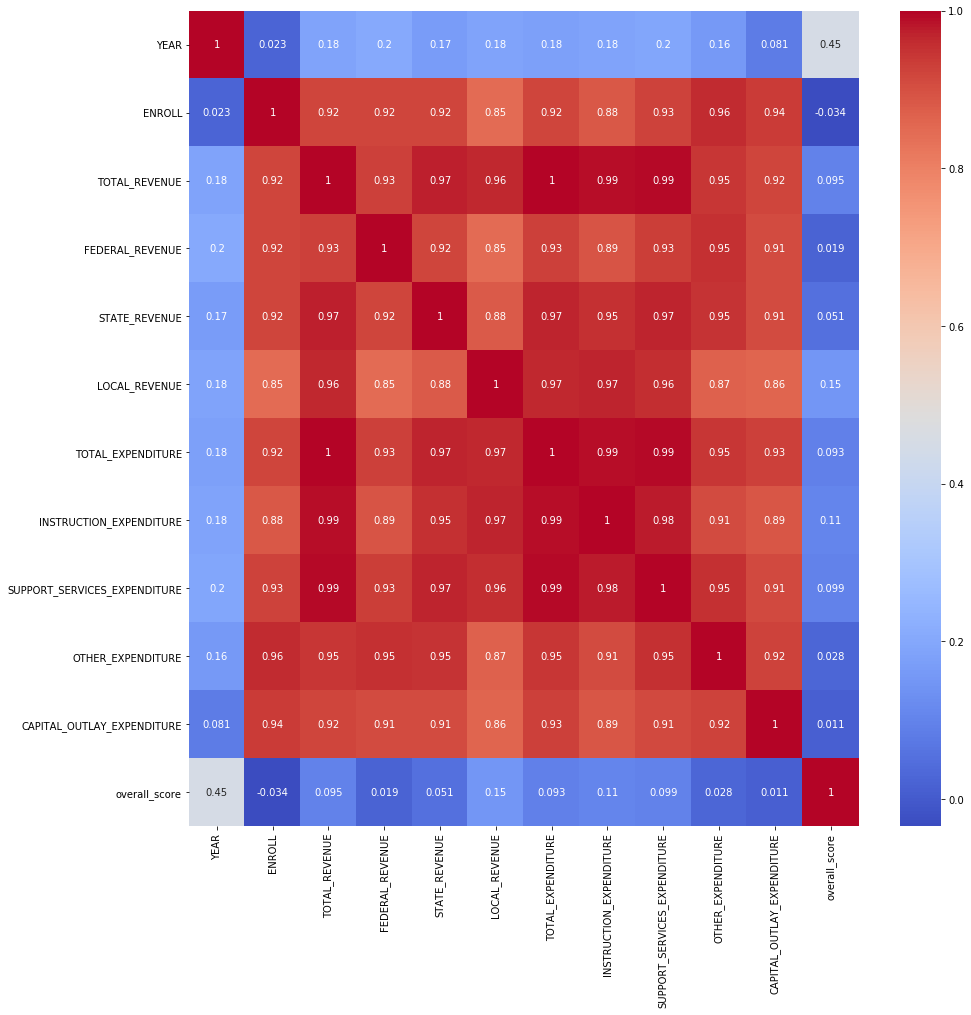

In [64]:
plt.figure(figsize = (15,15))
sns.heatmap(edu3_df.select_dtypes(include = 'number').corr(), annot=True, cmap='coolwarm')
plt.show()

In [76]:
edu3_df[["overall_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

,overall_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
overall_score,1.000000,0.093020,0.105787,0.098643,0.027635,0.010670
TOTAL_EXPENDITURE,0.093020,1.000000,0.990829,0.993175,0.946483,0.928576
INSTRUCTION_EXPENDITURE,0.105787,0.990829,1.000000,0.975867,0.907235,0.889763
SUPPORT_SERVICES_EXPENDITURE,0.098643,0.993175,0.975867,1.000000,0.953789,0.913680
OTHER_EXPENDITURE,0.027635,0.946483,0.907235,0.953789,1.000000,0.924197
CAPITAL_OUTLAY_EXPENDITURE,0.010670,0.928576,0.889763,0.913680,0.924197,1.000000


**Conclusion:** The INSTRUCTION_EXPENDITURE has the strongest correlation to test scores. However, it is pretty low  (.11). The year has the strongest correlation to test scores (as the year increased, the test scores increased as well). 

## 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [84]:
X = edu3_df[['INSTRUCTION_EXPENDITURE',
                          'SUPPORT_SERVICES_EXPENDITURE',
                          'OTHER_EXPENDITURE',
                          'CAPITAL_OUTLAY_EXPENDITURE']]
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=1)
edu3_df['pca_1'] = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.94568116])

## What is the correlation between the overall score variable and the 1st principal component?

In [85]:
edu3_df[['overall_score', 'pca_1']].corr()

,overall_score,pca_1
overall_score,1.000000,0.062716
pca_1,0.062716,1.000000


In [86]:
edu3_df[["overall_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", 'pca_1']].corr()

,overall_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,pca_1
overall_score,1.000000,0.093020,0.105787,0.098643,0.027635,0.010670,0.062716
TOTAL_EXPENDITURE,0.093020,1.000000,0.990829,0.993175,0.946483,0.928576,0.992264
INSTRUCTION_EXPENDITURE,0.105787,0.990829,1.000000,0.975867,0.907235,0.889763,0.970167
SUPPORT_SERVICES_EXPENDITURE,0.098643,0.993175,0.975867,1.000000,0.953789,0.913680,0.988317
OTHER_EXPENDITURE,0.027635,0.946483,0.907235,0.953789,1.000000,0.924197,0.973193
CAPITAL_OUTLAY_EXPENDITURE,0.010670,0.928576,0.889763,0.913680,0.924197,1.000000,0.957927
pca_1,0.062716,0.992264,0.970167,0.988317,0.973193,0.957927,1.000000


## 5. If you were to choose the best variables for your model, would you prefer using the first principal component instead of the expenditure variables? Why?


**Conclusion:** Instruction expenditure has a stronger correlation than PCA, so it's best to use that in the model instead. 